Este es el último modelo a desarrollar de este TFG, será un modelo utilizando la tecnología Attention U-Net.

Attention U-Net es una tecnología ligera y eficiente, por tanto, adecuada a los recursos utilizados en este TFG. Mejora el rendimiento de la arquitectura U-Net con respecto a los detalles pequeños, como los bordes del tumor o bordes pequeños.

Esta arquitectura es muy interesante para los tumores cerebrales porque en muchos casos, los tumores son muy pequeños y difíciles de detectar. Esta es una de las razones principales para desarrollar este modelo.

Descargamos el dataset con el que vamos a entrenar al modelo.

In [ ]:
#https://drive.google.com/file/d/19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB/view?usp=drive_link
import os
import gdown

# Reemplazamos con el ID del archivo compartido en Google Drive
file_id = "19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB"
output_file = "dataset.zip"

# Construimos el enlace de descarga y descargamos el archivo
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# Descomprimimos el archivo en la carpeta 'dataset'
!unzip -o dataset.zip -d dataset

Downloading...
From (original): https://drive.google.com/uc?id=19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB
From (redirected): https://drive.google.com/uc?id=19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB&confirm=t&uuid=9372ffa6-6064-47e8-887c-1b966e492051
To: /content/dataset.zip
100%|██████████| 369M/369M [00:06<00:00, 59.8MB/s]


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_

De igual manera, que en los modelos U-Net, se guardan las imágenes con las que se va a trabajar.

Pares de imagen/máscara encontrados: 3929
Ejemplo de rutas de imágenes: ['dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif', 'dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif', 'dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif']
Ejemplo de rutas de máscaras: ['dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif', 'dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif', 'dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif']
Dimensión de la imagen: (256, 256)
Dimensión de la máscara: (256, 256)


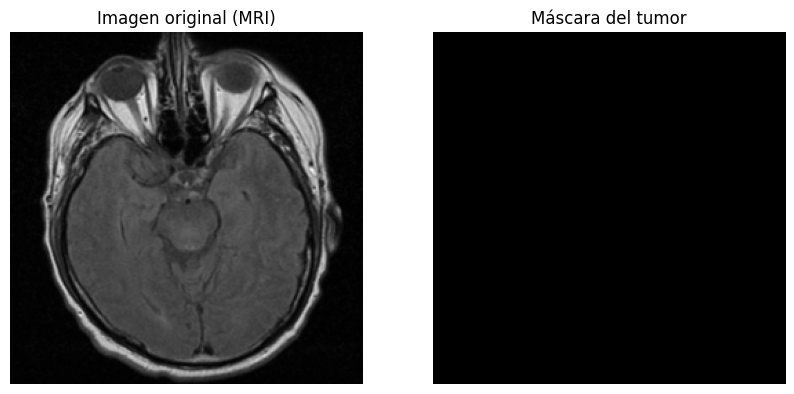

In [ ]:
#Primer paso, importar las librerías que vamos a utilizar
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#os la utilizaremos para manejar las rutas de los archivos
#cv2 la usaremos para cargar las imágenes
#numpy será de utilidad para las operaciones numéricas
#haremos uso de matplotlib para visualizar las imágenes


# Ruta del dataset
dataset_path = "dataset/lgg-mri-segmentation/kaggle_3m"

# Listas para almacenar rutas de imágenes y máscaras
image_paths = []
mask_paths = []

for folder in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        files = sorted(os.listdir(folder_path))
        # Crear un diccionario con claves base (sin _mask) para emparejar
        images = {f.replace('.tif', ''): os.path.join(folder_path, f)
                  for f in files if f.endswith('.tif') and '_mask' not in f}
        masks = {f.replace('_mask.tif', ''): os.path.join(folder_path, f)
                 for f in files if '_mask' in f}
        for key in images:
            if key in masks:
                image_paths.append(images[key])
                mask_paths.append(masks[key])

print(f"Pares de imagen/máscara encontrados: {len(image_paths)}")


# Verificar las primeras imágenes y máscaras encontradas
print("Ejemplo de rutas de imágenes:", image_paths[:3])
print("Ejemplo de rutas de máscaras:", mask_paths[:3])

#Una vez hemos encontrado las imágenes y las máscaras vamos a cargar una imagen y vamos a visualizarla
#Es muy importante antes de entrenar un modelo, entender el conjunto de datos
#Y la mejor manera de entenderlo es visualizarlo
#Como hemos explicado antes, usaremos cv2 para cargar imágeness y matplotlib para visualizarlas


# Seleccionamos una imagen y su máscara correspondiente
sample_idx = 1  # Se puede cambiar el índice para probarlo con distintas imágenes
image_path = image_paths[sample_idx]
mask_path = mask_paths[sample_idx]

# Cargamos la imagen y la máscara en escala de grises
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Verificamos las dimensiones tanto de la imagen como de la máscara
print("Dimensión de la imagen:", image.shape)
print("Dimensión de la máscara:", mask.shape)

# Mostramos la imagen y la máscara
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap="gray") #Imagen original en escala de grises
ax[0].set_title("Imagen original (MRI)") #Esto es simplemente para ponerle un título a la imagen

#Como no queremos que se muestren los ejes, los desactivamos con la función axis("off")
ax[0].axis("off")

#Y repetimos lo mismo con la máscara
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Máscara del tumor")
ax[1].axis("off")

plt.show()

Preprocesamiento de las imágenes (igual a los modelos anteriores).

In [ ]:
#Preprocesamiento de datos

#Primer paso, redimensionar las imágenes y normalizarlas

#Importamos las librerías, entre ellas PyTorch que va a ser la base de nuestro
#modelo de redes neuronales
import cv2
import torch
import numpy as np
from torchvision import transforms

# Definimos el tamaño deseado, en este caso vamos a utilizar imágenes de 256x256
IMG_SIZE = (256, 256)

# Transformaciones para normalizar las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertimos a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizamos a rango [-1, 1]
])

#Vamos a definir una función que dada una ruta de una imagen y una máscara, las preprocese
def preprocess_image(image_path, mask_path):
    # Cargamos la imagen y la máscara
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Redimensionamos ambas al tamaño deseado (256x256)
    image = cv2.resize(image, IMG_SIZE)
    mask = cv2.resize(mask, IMG_SIZE)

    # Convertimos la máscara a valores binarios (0 y 1)
    mask = (mask > 0).astype(np.float32)

    # Aplicamos transformaciones
    image = transform(image)
    mask = torch.tensor(mask).unsqueeze(0)  # Añadimos canal de profundidad

    return image, mask

# Probamos con una imagen
sample_idx = 0
image_tensor, mask_tensor = preprocess_image(image_paths[sample_idx], mask_paths[sample_idx])

# Verificamos tamaños
print("Tamaño del tensor de imagen:", image_tensor.shape)
print("Tamaño del tensor de máscara:", mask_tensor.shape)



Tamaño del tensor de imagen: torch.Size([1, 256, 256])
Tamaño del tensor de máscara: torch.Size([1, 256, 256])


Construcción de Dataset personalizado

In [ ]:
#Queremos definir un Dataset personalizado con PyTorch.
#Esta librería nos ofrece dos herramientas para ello, DataSet y DataLoader

#Los importamos
from torch.utils.data import Dataset, DataLoader

#Creamos una clase BrainTumorDataset
#que carga las imágenes y máscaras usando el método preprocess_image().
class BrainTumorDataset(Dataset):
  #Constructor de la clase
  def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
  #Función len que devuelve la longitud del dataset
  def __len__(self):
    return len(self.image_paths)
  #Función getitem que nmos devuelve el item del dataset en el índice pasado por parámetro
  def __getitem__(self, index):
      image, mask = preprocess_image(self.image_paths[index], self.mask_paths[index])
      return image, mask

#Creamos el dataset pasandole por parámetro las rutas de las imágenes y las rutas de las máscaras
dataset = BrainTumorDataset(image_paths, mask_paths)
#Verificamos el tamaño del dataset
print("Total de imágenes del dataset: ", len(dataset))


Total de imágenes del dataset:  3929


División del conjunto de datos en entrenamiento y validación

In [ ]:
from sklearn.model_selection import train_test_split

#Dividimos en entrenamiento (80%) y validación (20%), tanto para las imágenes como para las máscaras
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
#El parámetro ramdom_state es muy interesante para nosotros, porque queremos que el conjunto de datos sea reproducible,
#Y justamente este parámetro nos lo garantiza. Es importante mencionar que se puede asignar cualquier número,
#pero por alguna razón, la comunidad científica utiliza el 42.

# Creamos datasets
train_dataset = BrainTumorDataset(train_images, train_masks)
val_dataset = BrainTumorDataset(val_images, val_masks)

#Por último comprobamos que el tamaño de ambos datasets cuadran con lo que buscamos
print("Tamaño del dataset de entrenamiento:", len(train_dataset))
print("Tamaño del dataset de validación:", len(val_dataset))

Tamaño del dataset de entrenamiento: 3143
Tamaño del dataset de validación: 786


Carga de los datos en DataLoaders que cargará los datos en lotes de 8 ejemplos

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Verificamos un batch de datos
for images, masks in train_loader:
    print("Dimensiones del batch de imágenes:", images.shape)
    print("Dimensiones del batch de máscaras:", masks.shape)
    break

Dimensiones del batch de imágenes: torch.Size([8, 1, 256, 256])
Dimensiones del batch de máscaras: torch.Size([8, 1, 256, 256])


Este modelo, es bastante similar al desarrollado con U-Net, pero con algunas diferencias como el bloque de atención.

Este bloque de atención será el primero en ser definido.

Este bloque de atención sirve para que el modelo se centre en las zonas importantes de la imagen ignorando las partes que no son tan relevantes (el ruido).

In [ ]:
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):

        #Crea un bloque de atención.

        #F_g: canales del decoder (parte baja de la red)
        #F_l: canales del encoder (parte alta de la red)
        #F_int: canales intermedios, para reducir tamaño temporalmente
        super(AttentionBlock, self).__init__()

        # Transformamos la información del decoder
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        # Transformamos la información del encoder (skip connection)
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        # Calculamos "cuánta atención poner" en cada parte
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()  # Valor entre 0 (ignorar) y 1 (máxima atención)
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g = señal del decoder (información nueva)
        # x = señal del encoder (información antigua que salta al decoder)

        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        # Aplicamos la atención multiplicando
        return x * psi


Bloque de convolución, similar a los anteriormente utilizados. Este bloque convierte las imágenes en información que la red puede entender.

In [ ]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


Y ahora hay que juntar todo lo anterior en un esqueleto completo. Se define una clase AttentionUNet con las características que queramos (encoder, decoder, pool, bottleneck).

In [ ]:
class AttentionUNet(nn.Module):
    def __init__(self):
        super(AttentionUNet, self).__init__()

        # encoder: extrae características a varios niveles
        self.enc1 = conv_block(3, 64)        # Imagen original
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)          # Reduce tamaño (como hacer zoom-out)

        self.bottleneck = conv_block(512, 1024)  # Parte más profunda del modelo

        # decoder: reconstruye la imagen para segmentar
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(512, 512, 256)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(64, 64, 32)
        self.dec1 = conv_block(128, 64)

        # salida: 1 canal para máscara final (0 = fondo, 1 = tumor), como en los otros modelos
        # mascara en blanco y negro, negro el fondo y blanco el tumor
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        # Unimos el decoder con la atención definida anteriormente en el bloque de atención
        d4 = self.upconv4(b)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.upconv3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.upconv2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.upconv1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        return self.final(d1)


El bloque de código siguiente es exactamente igual que el del modelo 2, pero con pequeñas modificaciones, aquí no definimos la clase U-Net porque ya tenemos la clase Attention U-Net y cuando hacíamos UNet().to(DEVICE), lo cambiamos por AttentionUNet().to(DEVICE).

De igual forma, se calcula el DiceLoss y el IoU.

Se utiliza un optimizador diferente en este caso, AdamW. Este mejora el rendimiento sobre el Adam, desacoplando el decaimiento del peso de las actualizaciones del gradiente.
[Optimizador AdamW](https://www.datacamp.com/es/tutorial/adamw-optimizer-in-pytorch)



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# -----------------------------
# Configuración
# -----------------------------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
IMG_SIZE = (256,256)
IMG_DIM = 256
EPOCHS = 25

# -----------------------------
# Dataset personalizado
# -----------------------------
class TumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].unsqueeze(0)
            mask = mask / 255.0

        return img.float(), mask.float()

# -----------------------------
# Transformaciones
# -----------------------------
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Rotate(limit=15),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.Normalize(),
    ToTensorV2()
])



# -----------------------------
# Función de pérdida Dice
# -----------------------------
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

# -----------------------------
# Entrenamiento
# -----------------------------
def train(model, loader, optimizer, criterion, epoch_num=None):
    model.train()
    total_loss = 0
    num_batches = len(loader)

    for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


        if batch_idx % 5 == 0 or batch_idx == num_batches - 1:
            print(f"  Epoch {epoch_num} - Batch {batch_idx+1}/{num_batches} - Batch Loss: {loss.item():.4f}")

    return total_loss / num_batches

# -----------------------------
# Evaluación (IoU)
# -----------------------------
def evaluate(model, loader):
    model.eval()
    ious = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = torch.sigmoid(model(x)) > 0.5
            intersection = (preds & (y > 0.5)).float().sum((1,2,3))
            union = (preds | (y > 0.5)).float().sum((1,2,3))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.extend(iou.cpu().numpy())
    return np.mean(ious)

# -----------------------------
# Entrenamiento completo
# -----------------------------
def run_training(image_paths, mask_paths):
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42)

    train_dataset = TumorDataset(train_imgs, train_masks, transform=train_transform)
    val_dataset = TumorDataset(val_imgs, val_masks, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = AttentionUNet().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = DiceLoss()

    for epoch in range(EPOCHS):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_iou = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Val IoU: {val_iou:.4f}")


    return model

import random

def show_predictions(model, dataset, num=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num)
    fig, axs = plt.subplots(num, 3, figsize=(12, 4 * num))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        with torch.no_grad():
            pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))
            pred = (pred > 0.5).float().cpu().squeeze()

        axs[i, 0].imshow(img.permute(1, 2, 0).cpu())
        axs[i, 0].set_title('🧠 Imagen')

        axs[i, 1].imshow(mask.squeeze().cpu(), cmap='gray')
        axs[i, 1].set_title('✅ Máscara real')

        axs[i, 2].imshow(pred, cmap='gray')
        axs[i, 2].set_title('🔮 Predicción del modelo')

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()





Entrenamiento y guardado del modelo

  Epoch None - Batch 1/393 - Batch Loss: 0.9966
  Epoch None - Batch 6/393 - Batch Loss: 0.9683
  Epoch None - Batch 11/393 - Batch Loss: 0.9537
  Epoch None - Batch 16/393 - Batch Loss: 0.9749
  Epoch None - Batch 21/393 - Batch Loss: 0.9493
  Epoch None - Batch 26/393 - Batch Loss: 0.9246
  Epoch None - Batch 31/393 - Batch Loss: 0.9896
  Epoch None - Batch 36/393 - Batch Loss: 0.9309
  Epoch None - Batch 41/393 - Batch Loss: 0.9734
  Epoch None - Batch 46/393 - Batch Loss: 0.9562
  Epoch None - Batch 51/393 - Batch Loss: 0.9825
  Epoch None - Batch 56/393 - Batch Loss: 0.9609
  Epoch None - Batch 61/393 - Batch Loss: 1.0000
  Epoch None - Batch 66/393 - Batch Loss: 0.9981
  Epoch None - Batch 71/393 - Batch Loss: 0.8926
  Epoch None - Batch 76/393 - Batch Loss: 0.9297
  Epoch None - Batch 81/393 - Batch Loss: 0.9982
  Epoch None - Batch 86/393 - Batch Loss: 0.9573
  Epoch None - Batch 91/393 - Batch Loss: 0.9804
  Epoch None - Batch 96/393 - Batch Loss: 0.9093
  Epoch None - Batch 1

Epoch 25/25, Loss: 0.2586, Val IoU: 0.8346


<ipython-input-20-6667ab575ec6>:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-6667ab575ec6>:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-6667ab575ec6>:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


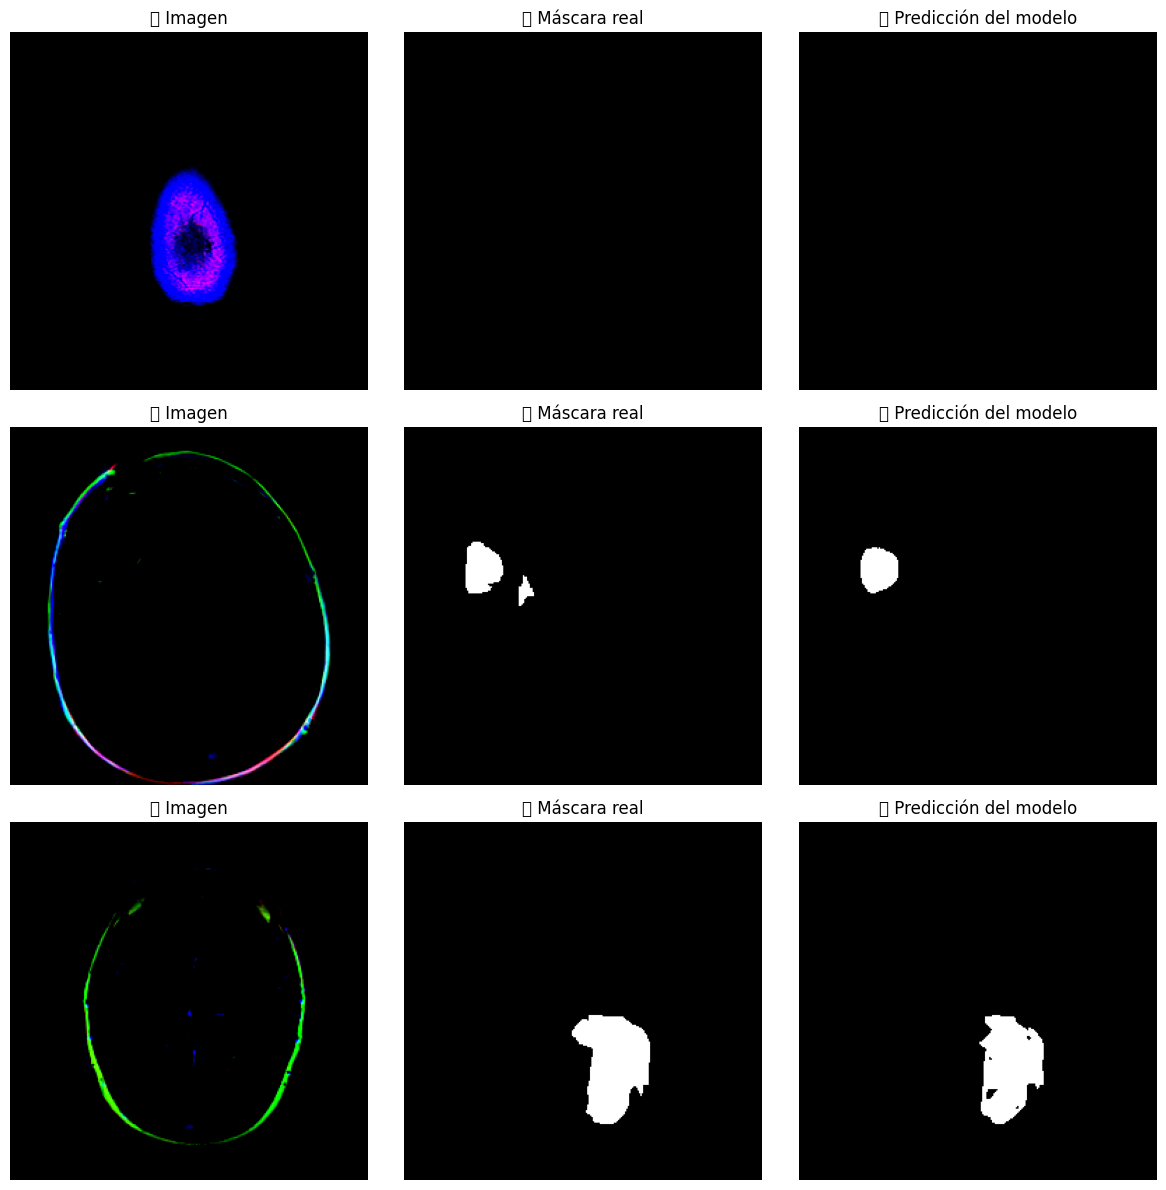

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = run_training(image_paths, mask_paths)

val_dataset_augmented = TumorDataset(val_images, val_masks, transform=test_transform)



torch.save(model.state_dict(), "modelo_tumores_attentionUNet.pth")

from google.colab import files
files.download("modelo_tumores_attentionUNet.pth")

In [ ]:
#Probar el modelo despues de entrenarlo
#Subir a google drive y compartirlo de manera pública
#Bajarme el modelo del google drive
#Y utilizarlo
#https://drive.google.com/file/d/1O1J8LuAqo-3lWkGj-_y6ECvlMBsFirbq/view?usp=drive_link
!pip install gdown

import gdown

#ID del modelo en Google Drive
file_id = "1O1J8LuAqo-3lWkGj-_y6ECvlMBsFirbq"
output = "modelo_tumores_attentionUNet.pth"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1O1J8LuAqo-3lWkGj-_y6ECvlMBsFirbq
From (redirected): https://drive.google.com/uc?id=1O1J8LuAqo-3lWkGj-_y6ECvlMBsFirbq&confirm=t&uuid=0c8c8079-f3b7-42c2-8ce9-2562366dd43a
To: /content/modelo_tumores_attentionUNet.pth
100%|██████████| 126M/126M [00:02<00:00, 47.1MB/s]


'modelo_tumores_attentionUNet.pth'

In [ ]:
model = AttentionUNet().to(DEVICE)
model.load_state_dict(torch.load("modelo_tumores_attentionUNet.pth"))
model.eval()

AttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [ ]:
#Interfaz gradio simplemente para hacer pruebas, no es la interfaz definitiva pero sirve para probar con algunas imagenes

!pip install gradio

import gradio as gr
from PIL import Image
import cv2
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_DIM = 256


class AttentionUNet(nn.Module):
    def __init__(self):
        super(AttentionUNet, self).__init__()

        # encoder: extrae características a varios niveles
        self.enc1 = conv_block(3, 64)        # Imagen original
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)          # Reduce tamaño (como hacer zoom-out)

        self.bottleneck = conv_block(512, 1024)  # Parte más profunda del modelo

        # decoder: reconstruye la imagen para segmentar
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(512, 512, 256)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(64, 64, 32)
        self.dec1 = conv_block(128, 64)

        # salida: 1 canal para máscara final (0 = fondo, 1 = tumor), como en los otros modelos
        # mascara en blanco y negro, negro el fondo y blanco el tumor
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        # Unimos el decoder con la atención definida anteriormente en el bloque de atención
        d4 = self.upconv4(b)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.upconv3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.upconv2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.upconv1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        return self.final(d1)

def predict_gradio(img_pil):
    # Convertimos PIL a OpenCV
    img = np.array(img_pil)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    transform = A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.Normalize(),
        ToTensorV2()
    ])

    augmented = transform(image=img_rgb)
    img_tensor = augmented['image'].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))
        pred_mask = (pred > 0.5).float().cpu().squeeze().numpy()


    mask_colored = np.zeros_like(img_rgb)
    mask_colored[:,:,0] = (pred_mask * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_rgb, 0.8, mask_colored, 0.5, 0)
    overlay_pil = Image.fromarray(overlay)

    return img_pil, overlay_pil

interface = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil", label="Imagen original"),
             gr.Image(type="pil", label="Predicción del modelo")],
    title="🧠 Detector de Tumores Cerebrales",
    description="Sube una imagen MRI de cerebro y el modelo detectará el tumor"
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://246a28bfc62ae24028.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
